In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [3]:
filename = 'data/train4.csv'
place_list = [6, 7, 8] # 选取的地点
all_place_list = list(range(1, 34)) # 所有地点的列表
year = 2017         # 样本的年份
date_start = 20170701  # 截取日期的起点

In [5]:
def is_weekend(x):
    x = datetime.strptime(str(x), '%Y%m%d')
    if x.weekday() + 1 in (6, 7):
        return True
    else:
        return False

In [8]:
# 读取数据
data = pd.read_csv(filename, dtype=object, header=None)
data[0] = data[0].apply(pd.to_numeric)
data[2] = data[2].apply(pd.to_numeric)
n_data = data.shape[0]
place_1, place_2, place_3 = place_list[0], place_list[1], place_list[2]
data_1 = pd.Series(data[data[0]==place_1][2])
data_1.index = data[data[0]==place_1][1]
data_2 = pd.Series(data[data[0]==place_2][2])
data_2.index = data[data[0]==place_2][1]
data_3 = pd.Series(data[data[0]==place_3][2])
data_3.index = data[data[0]==place_3][1]

d:\python\python35\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


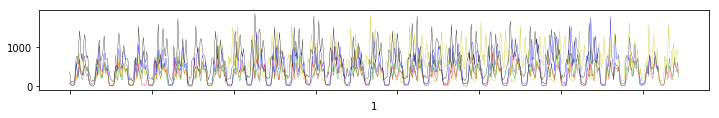

In [19]:
fig = plt.figure(figsize=(12, 5))
fig.subplots_adjust(wspace=None, hspace=None)
ax = fig.add_subplot(3, 1, 1)
#ax.set_title('Place-'+'6, 7, 8'+' Time Series', fontproperties='SimHei', fontsize=13)
plt.subplot(311)
data_1[:744].plot(label='Place'+str(place_1), style='r-', use_index=True, linewidth=0.3)
data_1[744:1488].plot(style='g-', use_index=True, linewidth=0.3)
data_1[1488:2208].plot(style='b-', use_index=True, linewidth=0.3)
data_1[2208:2951].plot(style='y-', use_index=True, linewidth=0.3)
data_1[2951:].plot(style='k-', use_index=True, linewidth=0.3)

In [18]:
data_1

1
2017-07-01 00      86.0
2017-07-01 01      44.0
2017-07-01 02       9.0
2017-07-01 03      11.0
2017-07-01 04      15.0
2017-07-01 05      19.0
2017-07-01 06      63.0
2017-07-01 07     105.0
2017-07-01 08     169.0
2017-07-01 09     286.0
2017-07-01 10     278.0
2017-07-01 11     617.0
2017-07-01 12     708.0
2017-07-01 13     327.0
2017-07-01 14     295.0
2017-07-01 15     324.0
2017-07-01 16     275.0
2017-07-01 17     449.0
2017-07-01 18     509.0
2017-07-01 19     431.0
2017-07-01 20     283.0
2017-07-01 21     246.0
2017-07-01 22     321.0
2017-07-01 23     197.0
2017-07-02 00      48.0
2017-07-02 01      11.0
2017-07-02 02      10.0
2017-07-02 03      14.0
2017-07-02 04       6.0
2017-07-02 05       7.0
                  ...  
2017-11-29 18    1156.0
2017-11-29 19     887.0
2017-11-29 20     631.0
2017-11-29 21     662.0
2017-11-29 22     820.0
2017-11-29 23     639.0
2017-11-30 00     453.0
2017-11-30 01     253.0
2017-11-30 02     246.0
2017-11-30 03     267.0
2017-11-30 04 

In [ ]:

#plt.xticks(['2017-07-01 00','2017-08-01 00','2017-09-01 00','2017-10-01 00','2017-11-01 00'],['7-1','8-1','9-1','10-1','11-1'])
plt.tick_params(axis='x',width=2,colors='k')
plt.tick_params(axis='y',width=2,colors='k')
ax.spines['top'].set_visible(False) #去掉上边框
ax.spines['bottom'].set_visible(False) #去掉下边框
ax.spines['left'].set_visible(False) #去掉左边框
ax.spines['right'].set_visible(False) #去掉右边框